In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from __future__ import absolute_import, division, print_function

import re
import os
import sys
import datetime
import itertools
import warnings
import math

import pandas as pd
import pandas_datareader.data as web
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)

# Display and Plotting
import matplotlib.pyplot as plt
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 16, 8
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})


from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress

from IPython.display import set_matplotlib_formats, Image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 5. ARIMA Forecasting

An autoregressive integrated moving average (ARIMA) model is an generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity. - <a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average">Wikipedia</a>

In [11]:
# load passenger data set and save to DataFrame
pas = pd.read_csv('./data/passengers.csv', header=0, index_col=0, parse_dates=True, sep=';')
y = pas['n_passengers']

In [12]:
# split into training and test sets
y_train = y[:'1958']
y_test = y['1959':]
y_test

month
1959-01-01    360
1959-02-01    342
1959-03-01    406
1959-04-01    396
1959-05-01    420
1959-06-01    472
1959-07-01    548
1959-08-01    559
             ... 
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: n_passengers, Length: 24, dtype: int64

## 5.1 The ARIMA model

In the base model there are three parameters $(p, d, q)$ that are used to parametrize ARIMA models. Hence, an ARIMA model is denoted as $ARIMA(p, d, q)$ and is defined by

$$
\left(1 - \sum_{i=1}^p \phi_i L^i \right) (1 - L)^d y_t = \mu + \left(1 + \sum_{i=1}^q \theta_i L^i \right) \varepsilon_t
$$

Each of these three parts is an effort to make the time series stationary, i. e. make the final residual a white noise pattern. <strong>These three transformations are applied in sequence to the original series. </strong>

A good resource for a quick mathematical overview of ARIMA processes is given <a href="http://users.dma.unipi.it/~flandoli/AUTCap4.pdf">here</a>.



## 5.2 Optimal Parameter Selection

To fit the time series data to a seasonal ARIMA model with parameters $ARIMA(p, d, q)(P, D, Q)s$ the optimal parameters need to be found first. This is done via <strong>grid search</strong>, the iterative exploration of all possible parameters constellations. Since there is no way of doing this automatically in Python we have to resort to doing this ourselves.

Depending on the size of the model parameters $(p, d, q)(P, D, Q)s$ this can become an extremely costly task with regard to computation. We start of by generating all possible parameter constellation we'd like to evaluate.

In [9]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [12]:
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

For all possible parameter constellations from both lists <code>pdq</code> and <code>seasonal_pdq</code> the alogrithm will create a model and eventually pick the best one to proceed. The best model is chosen based on the <strong>Akaike Information Criterion (AIC)</strong>. 

The Akaike information criterion (AIC) is a measure of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Hence, AIC provides a means for model selection. - <a href="https://en.wikipedia.org/wiki/Akaike_information_criterion">Wikipedia</a>

It measures the trade-off between the goodness of fit of the model and the complexity of the model (number of included and estimated aprameters). The AIC is calculated as follows

$$
AIC = 2k - 2ln(L)
$$

where $k$ corresponds to the number of estimated parameters in the model and $L$ refers to the maximum value of the likelihood function for the model.

In [57]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            res = tmp_mdl.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 0)x(1, 2, 1, 12)12 model - AIC:821.9362038657893


The grid search found that the best model is a seasonal ARIMA model $ARIMA(2, 1, 3)(1, 2, 1)12$ for <code>y</code> and $ARIMA(1, 1, 0)(1, 2, 1)12$ for <code>y_test</code>. We can train a SARIMAX model on the data with the following code

In [38]:
mdl = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1, 1, 0),
                                seasonal_order=(1, 2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()

In [39]:
print(res.aic)
print(res.summary().tables[1])

727.325689291
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3570      0.091     -3.909      0.000      -0.536      -0.178
ar.S.L12      -0.2319      0.124     -1.868      0.062      -0.475       0.011
ma.S.L12      -0.9095      0.459     -1.981      0.048      -1.809      -0.010
sigma2        88.5371     28.783      3.076      0.002      32.124     144.950


The <code>summary</code> attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of coefficients. The <code>coef</code> column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The <code>P>|z|</code> column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

The <code>res</code> object has convenient diagnostic function, for example we can make use of the <code>plot_diagnostics</code> method to get a quick rundown of our fitted model

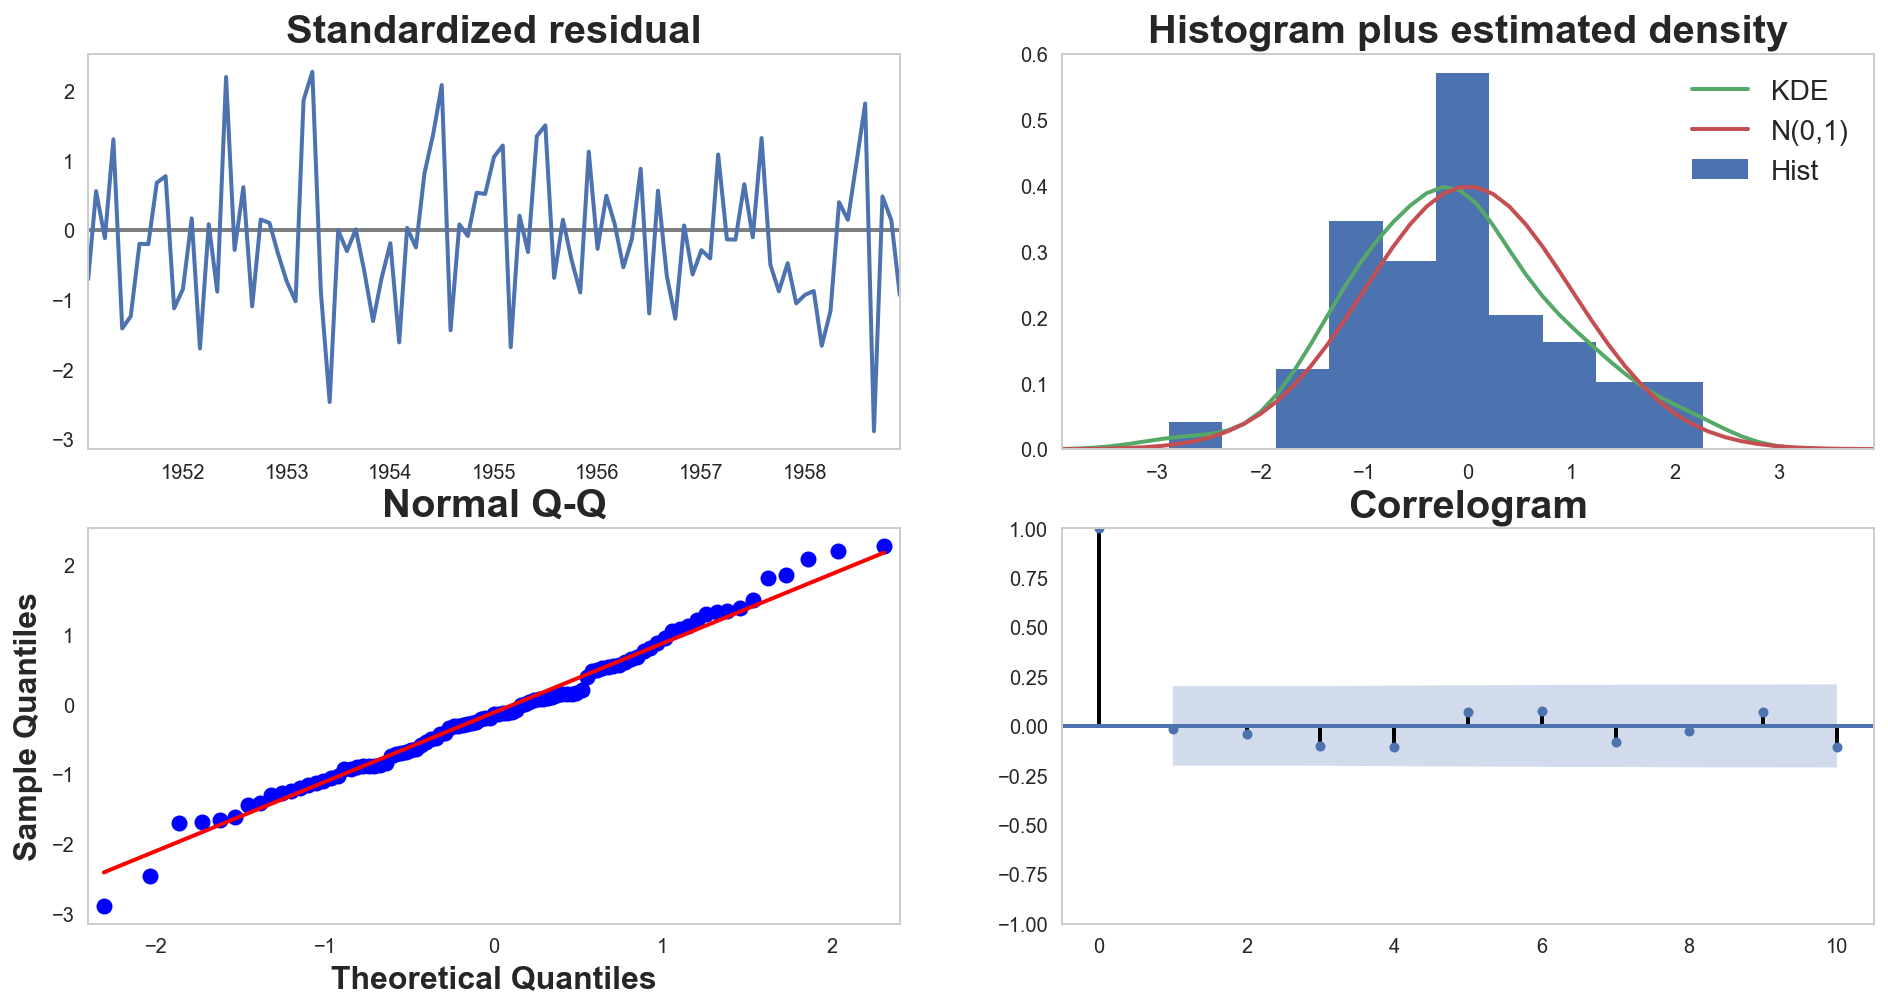

In [40]:
res.plot_diagnostics()
plt.show()

We need to ensure that the residuals of our model are dnormally distributed with zero-mean and not serially correlate, i. e. we'd like the remaining information to be white noise. If the fitted seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

<strong>Inference</strong>
<ul>
<li>The residual plot of the fitted model in the upper right corner appears do be white noise as it does not display obvious seasonality or trend behaviour.</li>
<li>The histogram plot in the upper right corner pair with the kernel density estimation (red line) indicates that the time series is almost normally distributed. This is compared to the density of the standard normal distribution (green line).</li>
<li>The correlogram (autocorrelation plot) confirms this resuts, sicne the time series residuals show low correlations with lagged residuals.</li>
</ul>

Those observations coupled with the fact that there are no spikes outside the insignificant zone for both ACF and PACF plots lead us to conclude that that residuals are random with little information left in them. The model produces a satisfactory fit that can help us understand our time series data and forecast future values. Although the fit so far appears to be fine, we might have found a better fit with a more complex model, i.e. if we would have increased the parameter grid for higher order lags.


## 4.3 One step ahead prediction

So far we have accomplished to create a time series model which we can use to produce predictions. Using the <code>get_prediction</code> and <code>conf_int</code> methods we can calculate predictions and associated confidence intervals for future points in time for the previously fitted model. The <code>dynamic=False</code> argument causes the method to produce a one-step ahead prediction of the time series

In [55]:
pred = res.get_prediction(start=pd.to_datetime('1958-12-01'), 
                          end=pd.to_datetime('1960-12-01'),
                          dynamic=True)
pred_ci = pred.conf_int()

We then plot the true and the predicted values along with the corresponding confidence bound of the prediction

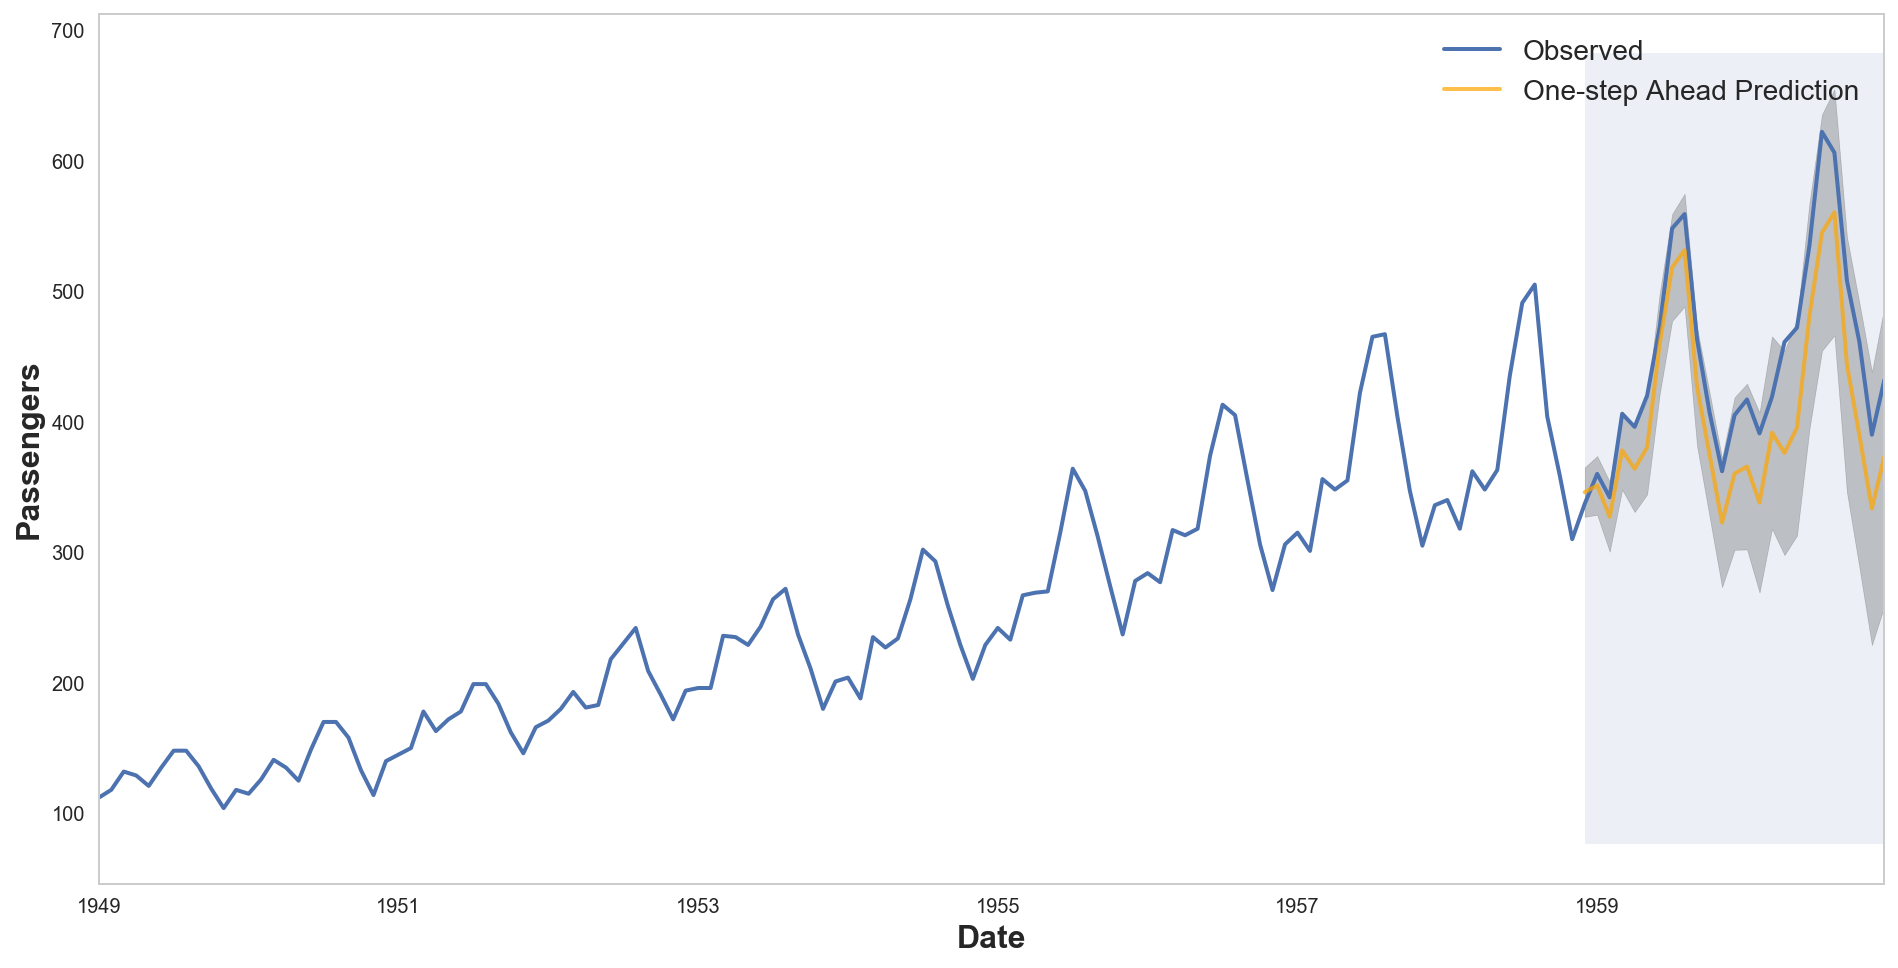

In [58]:
ax = y['1949':].plot(label='Observed');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='orange');

# draw confidence bound (gray)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2);

# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-12-01'), y.index[-1], alpha=.1, zorder=-1);
ax.set_xlabel('Date');
ax.set_ylabel('Passengers');
plt.legend();

plt.show()

To quantify the accuracy between model fit and true observations wie will use the <strong>mean squared error</strong> (MSE) for cross validation. The MSE computes the squared difference between the true and predicted value.  The MSE is calculated as follows

$$
MSE = \frac{1}{T} \sum_{t=1}^T \left(\hat{y}_t - y_t \right)^2
$$

In [59]:
y_prediction = pred.predicted_mean
y_true = y['1958-12-01':]

# Compute the mean square error
mse = ((y_prediction - y_true) ** 2).mean()
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Test Score: 2305.04 MSE (48.01 RMSE)


The one-step ahead prediction yielded a value of 246.14, which appears reasonal comparing to the plot above for a prediction period of two years.


## Out of sample prediction

It is time to put our model to the real test with a 24-month-head prediction. This requires us to pass the argument <code>dynamic=True</code> when using the <code>get_prediction</code> method.

In [60]:
pred_dynamic = res.get_prediction(start=pd.to_datetime('1958-12-01'), 
                                  end=pd.to_datetime('1960-12-01'), 
                                  dynamic=False, full_results=True)
pred_dynamic_ci = pred_out.conf_int()

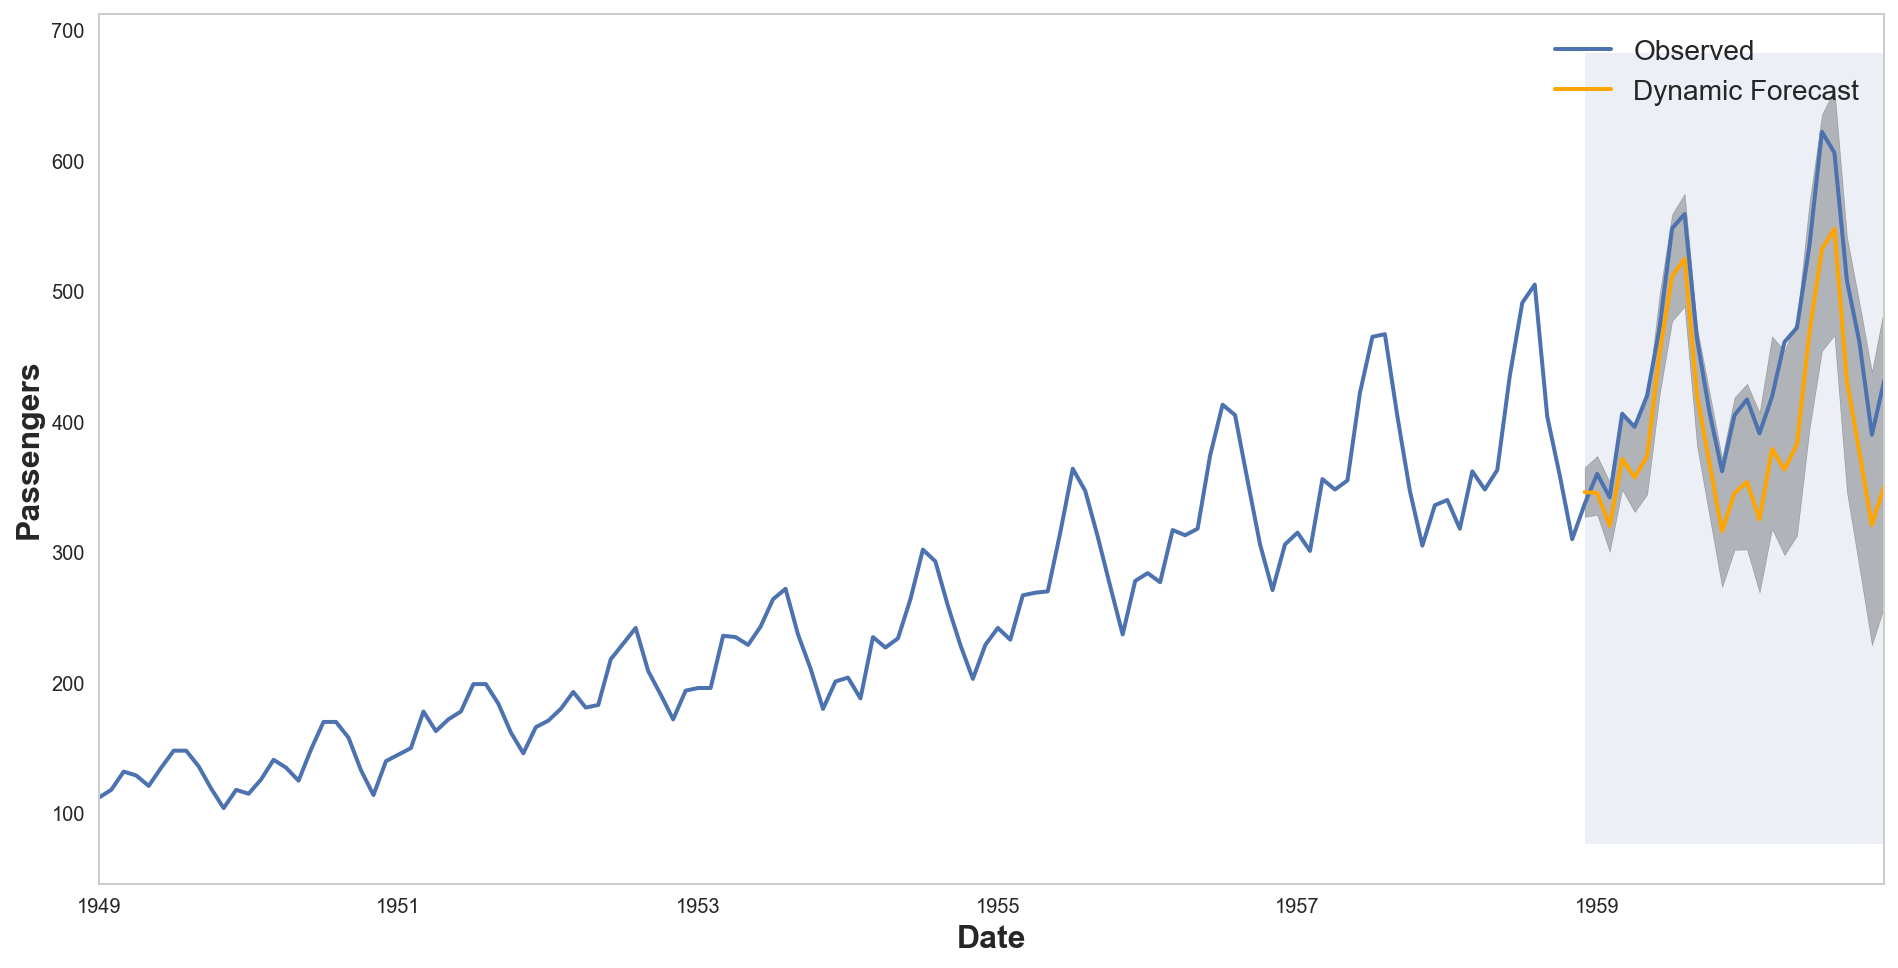

In [61]:
ax = y['1949':].plot(label='Observed')
pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic Forecast', color='orange')

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-12-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()

plt.show()

It is obvious that, the further we try to extrapolate the time series evolution into the future, the less confident our prediction becomes. Hence, the confidence bound widens in the course of time. Moreover, we notic in the plot above that our model seems to systematically underestimate future values. It seems that there must have been a systematic pattern left in the time series which we were not able to extract with the seasonal ARIMA model.

Again, quantifying the accuracy of the prediction with the MSE criterion

In [62]:
# extract the predicted and true values of our time series
y_forecast = pred_dynamic.predicted_mean
y_true = y['1958-12-01':]

# compute the mean square error
mse = ((y_forecast - y_true) ** 2).mean()
print('Test Score: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Test Score: 3406.72 MSE (58.37 RMSE)


## Long term forecasting

Finally we will produce a 10 year ahead forecast, leverageing a seasonal ARIMA model trained on the complete time series <code>y</code>. Training the model with

In [83]:
mdl = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 1, 3),
                                seasonal_order=(1, 2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()

and invoking the <code>get_prediction</code> method on <code>res</code> object

In [84]:
# get forecast 120 steps ahead in future
pred_uc = res.get_forecast(steps=120)

# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

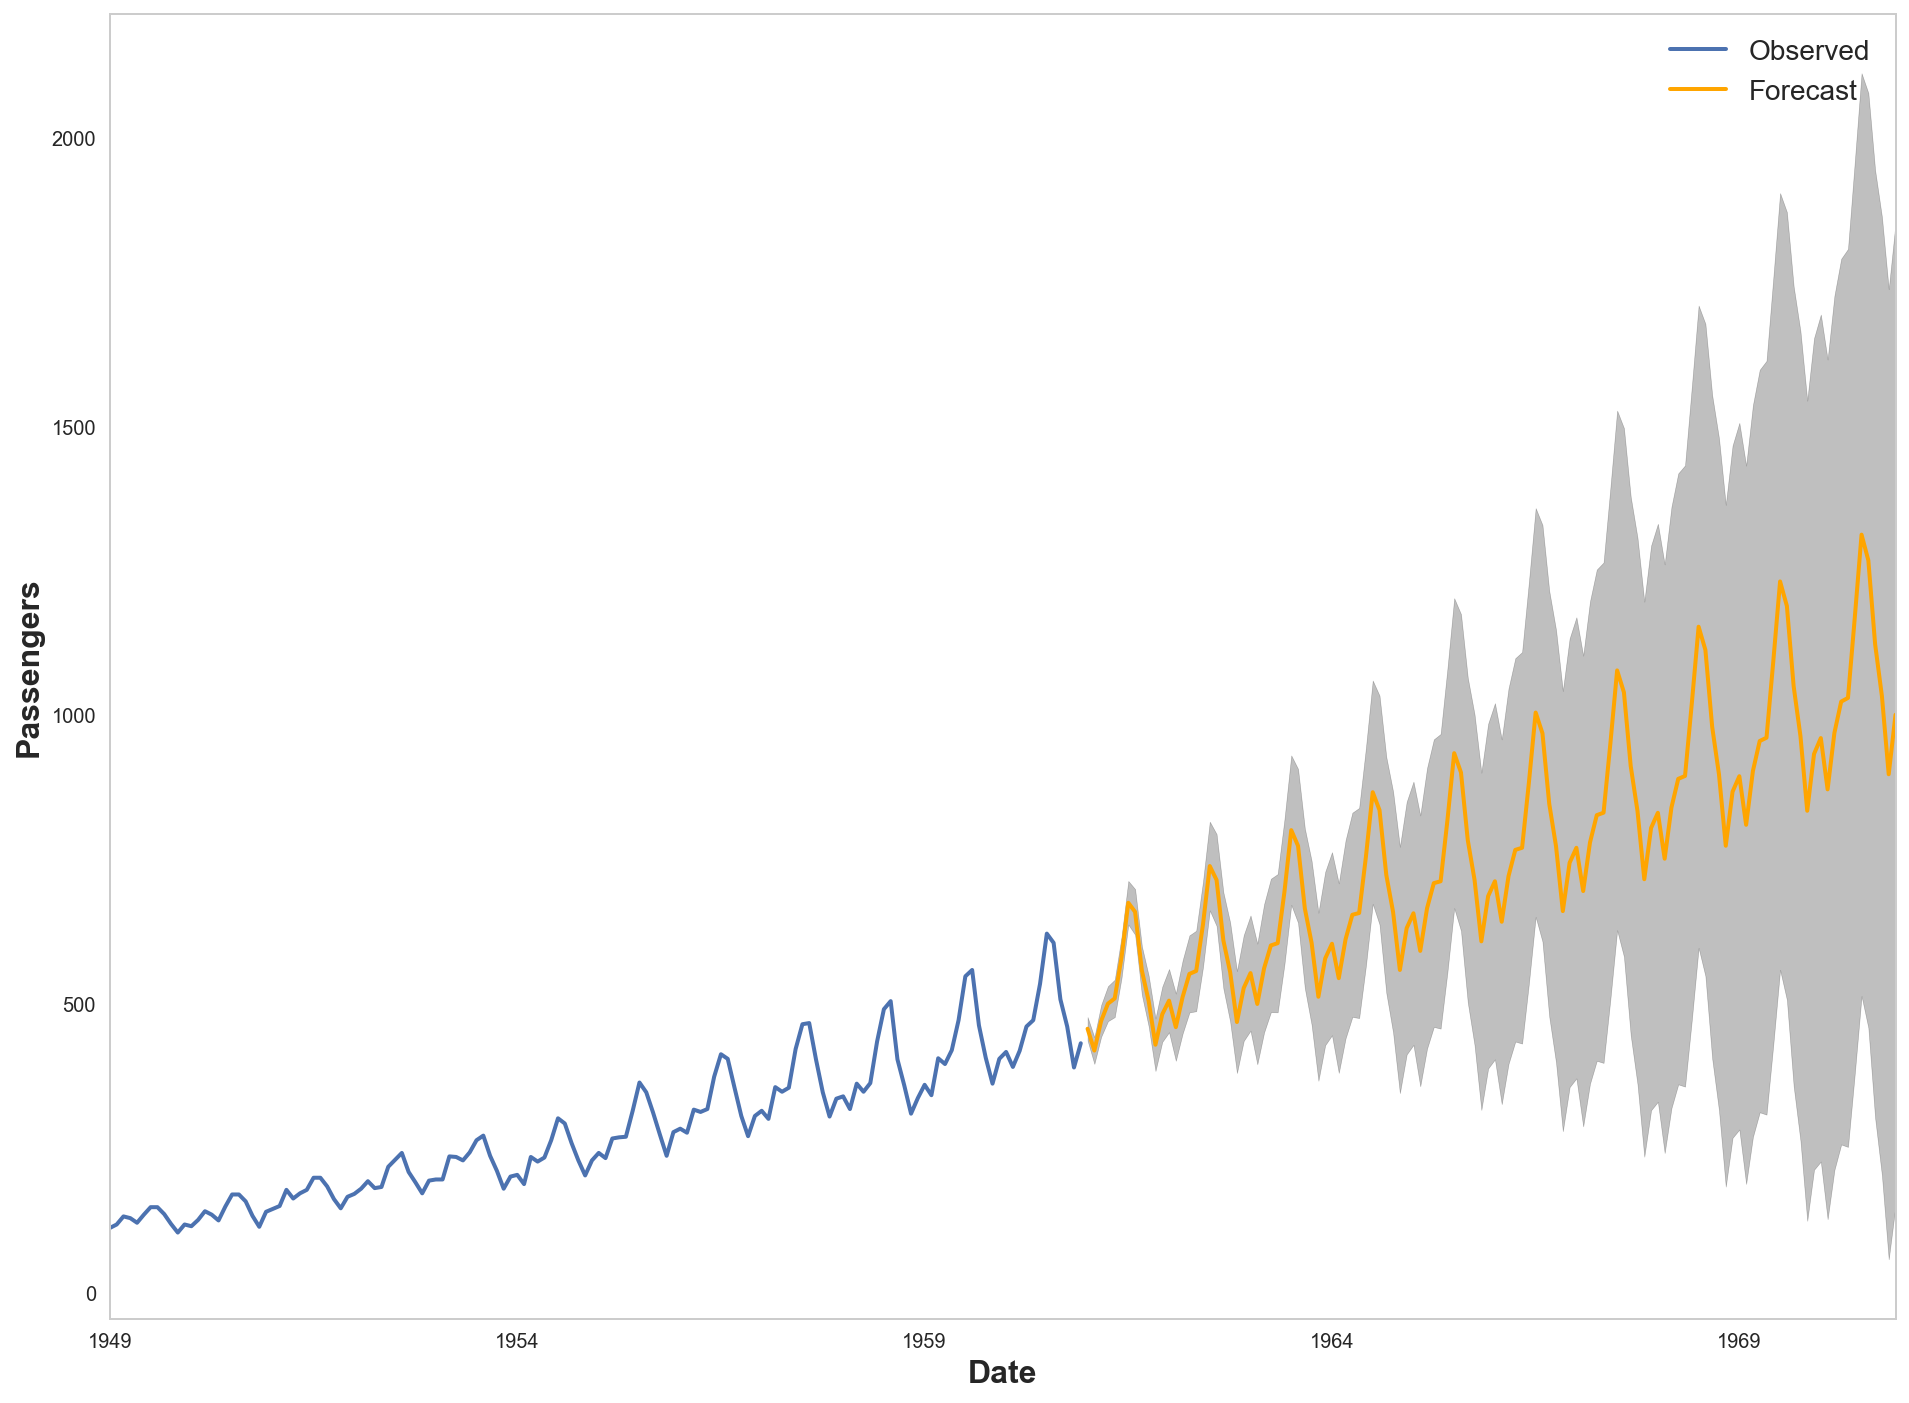

In [85]:
ax = y.plot(label='Observed', figsize=(16, 12));
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='orange');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Passengers');

plt.legend();
plt.show()

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. The forecast shows that the time series is expected to continue increasing at a steady pace. Moreover, the seasonal magnitude is expected to grow over the years also.

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.